<a href="https://colab.research.google.com/github/yurigalindo/FilteringMeteors/blob/master/folds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls /content/gdrive/My\ Drive

 Classroom
'Cópia de DPS calculator by Bitterkoekje.gsheet'
 csvs.zip
'Documento sem título.gdoc'
 final_csvs
 labeled_data.zip
 Mix.zip
 Relatório.gdoc
 test0.csv
'Trabalho final - Parte 2.gdoc'
 train0.csv


In [0]:
!rm -r csvs
!unzip /content/gdrive/My\ Drive/csvs.zip -d csvs

Archive:  /content/gdrive/My Drive/csvs.zip
  inflating: csvs/__Mdates0test.csv  
  inflating: csvs/__Mdates0train.csv  
  inflating: csvs/__Mdates1test.csv  
  inflating: csvs/__Mdates1train.csv  
  inflating: csvs/__Mdates2test.csv  
  inflating: csvs/__Mdates2train.csv  
  inflating: csvs/__Mdates3test.csv  
  inflating: csvs/__Mdates3train.csv  
  inflating: csvs/__Mdates4test.csv  
  inflating: csvs/__Mdates4train.csv  
  inflating: csvs/__Mplacedates0test.csv  
  inflating: csvs/__Mplacedates0train.csv  
  inflating: csvs/__Mplacedates1test.csv  
  inflating: csvs/__Mplacedates1train.csv  
  inflating: csvs/__Mplacedates2test.csv  
  inflating: csvs/__Mplacedates2train.csv  
  inflating: csvs/__Mplacedates3test.csv  
  inflating: csvs/__Mplacedates3train.csv  
  inflating: csvs/__Mplacedates4test.csv  
  inflating: csvs/__Mplacedates4train.csv  
  inflating: csvs/__Mplaces0test.csv  
  inflating: csvs/__Mplaces0train.csv  
  inflating: csvs/__Mplaces1test.csv  
  inflating: csvs/

In [0]:
!unzip /content/gdrive/My\ Drive/Mix.zip -d mixedCaptures

Archive:  /content/gdrive/My Drive/Mix.zip
   creating: mixedCaptures/Meteoros/
  inflating: mixedCaptures/Meteoros/M20180101_030747_FFD_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20180108_013859_FFD_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20180109_002140_FFD_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_035622_OMC_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_040322_GBS_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_041719_OMC_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_043018_OMC_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_045057_ITU_2P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_050735_ITU_2P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_051235_SJU_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_051820_ITU_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_052259_RJK_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_052302_GBS_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_052749_VIX_2P.jp

In [0]:
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
import os
import os.path
from torch.utils.data import Dataset
from torchvision import get_image_backend

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def default_loader(path):
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
      return pil_loader(path)

class ImageFromCSV(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        image = default_loader(img_name)
        label = self.csv.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image , label

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomOrder([
          transforms.Resize((350,350))
          #transforms.RandomHorizontalFlip(),
          #transforms.RandomRotation(45),
          #transforms.RandomVerticalFlip()
          ]
        ),
        #transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((420,420)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'mixedCaptures'
image_datasets = {x + f'{i}': ImageFromCSV("csvs/__Mdates{0}{1}.csv".format(i,x),"mixedCaptures/Meteoros",transform=data_transforms[x])
                  for i in range(5) for x in ['train','test']}

In [0]:
print(image_datasets)

{'train0': <__main__.ImageFromCSV object at 0x7f09f9ee03c8>, 'test0': <__main__.ImageFromCSV object at 0x7f09f9ee0400>, 'train1': <__main__.ImageFromCSV object at 0x7f0a6e3a8630>, 'test1': <__main__.ImageFromCSV object at 0x7f0a74f0a048>, 'train2': <__main__.ImageFromCSV object at 0x7f09f96b4128>, 'test2': <__main__.ImageFromCSV object at 0x7f09f96b4278>, 'train3': <__main__.ImageFromCSV object at 0x7f09f96b43c8>, 'test3': <__main__.ImageFromCSV object at 0x7f09f96b4518>, 'train4': <__main__.ImageFromCSV object at 0x7f09f96b4668>, 'test4': <__main__.ImageFromCSV object at 0x7f09f96b47b8>}


In [0]:
#dataloader=torch.utils.data.DataLoader(image_datasets['train'])
plt.ion() 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

print(inputs)
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)
#del dataloader

NameError: ignored

In [0]:
import matplotlib.pyplot as plt
import torch

class Learner:
    #adapt code for emulating big batches
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_acc=0

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            size=inputs.size(0)
            del inputs
            loss = self.criterion(outputs, labels)
            #loss.requires_grad=True
            loss.backward()
            
        with torch.no_grad():
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item() 
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("  Avg Loss={}\n  Accuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a
    def change_to_best_model(self):
        self.model.load_state_dict(self.best_model_wts)
    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        batch_cap=self.min_value(training_batchsize,batch_cap)
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=batch_cap,shuffle=True)
        
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            print("Epoch {} of {}".format(epoch,num_epochs-1))
            
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            #for batch in range(training_batches):
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                try:
                  for micro_batch in range(micro_batches):

                    inputs,labels=next(iterator)
                    new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                    loss+=new_loss
                    corrects+=new_corrects
                    del inputs
                    del labels
                    del new_loss
                    del new_corrects
                    torch.cuda.empty_cache()
                except StopIteration:
                    pass
                self.optimizer.step()
                torch.cuda.empty_cache()

            self.scheduler.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            train_losses.append(loss/len(self.training_dataset))
            print("Training:")
            self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss/len(self.validation_dataset))
            acc=corrects/len(self.validation_dataset)
            print("Validation:")
            self.print_statistics(loss/len(self.validation_dataset),acc)
            print()
            if(acc>self.best_acc):
              self.best_acc=acc
              self.best_model_wts = copy.deepcopy(self.model.state_dict())
            

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Return a tensor containing the probabilities of each class
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        #for layer in self.model.children():  
        #  if isinstance(layer, nn.BatchNorm2d):
        #    layer.eval()
        self.model.eval()
        self.optimizer.zero_grad()
        #self.model.train()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class FlattenTo1d(nn.Module):
    def __init__(self,num_classes):
        self.n=num_classes
        super(FlattenTo1d, self).__init__()

    def forward(self, x):
       return x.view(-1,self.n)


4fold
Epoch 0 of 4
Training:
  Avg Loss=0.4512706913698425
  Accuracy=0.7860394537177542
Validation:
  Avg Loss=0.4864336877263665
  Accuracy=0.767639902676399

Epoch 1 of 4
Training:
  Avg Loss=0.2642256361399869
  Accuracy=0.9013657056145675
Validation:
  Avg Loss=0.9481115490560694
  Accuracy=0.5693430656934306

Epoch 2 of 4
Training:
  Avg Loss=0.15113481895288675
  Accuracy=0.9438543247344461
Validation:
  Avg Loss=0.9055161567500037
  Accuracy=0.5523114355231143

Epoch 3 of 4
Training:
  Avg Loss=0.1258794275780911
  Accuracy=0.9550834597875569
Validation:
  Avg Loss=0.7840365359963002
  Accuracy=0.572992700729927

Epoch 4 of 4
Training:
  Avg Loss=0.09562311661125858
  Accuracy=0.9635811836115327
Validation:
  Avg Loss=1.457360642089751
  Accuracy=0.5206812652068127

Total time:290.35812520980835


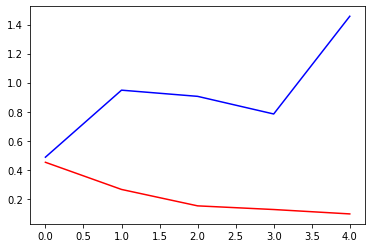

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
for i in range(5):
  model_ft = models.alexnet(pretrained=True)
  model_ft=nn.Sequential(
      model_ft.features,
      nn.Conv2d(256,2,1), #2048 for resnet50
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )
  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  learner = Learner(model_ft,criterion)

  optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train{i}'],image_datasets[f'test{i}'])
  print(f'{i}fold')
  learner.train(5,64,128,batch_cap=32)

In [0]:
def confusion_matrix(predictions,true_labels):
  
  TP=FP=TN=FN=PASSED=0
  label_evaluation=torch.argmax(predictions, dim=2)
  #print(label_evaluation.size())
  predicted_labels =(label_evaluation==1).sum(dim=0)
  #print(predicted_labels)
  #should take in account the number of evals
  #print(predicted_labels.size())
  for i in range(len(predicted_labels)):
    if(predicted_labels[i]<=10):
      if(true_labels[i]==0):
        TP+=1
      else:
        FP+=1
    elif(predicted_labels[i]>=90):
      if(true_labels[i]==1):
        TN+=1
      else:
        FN+=1
    else:
      PASSED+=1
  print("TP: {0} FP: {1}".format(TP,FP))
  print("FN: {0} TN: {1}".format(FN,TN))
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1=2*precision*recall/(precision+recall)
  acc=(TP+TN)/(TP+TN+FP+FN)
  print("precision:{0},recall:{1},F1:{2},acc:{3},coverage:{4}".format(precision,recall,F1,acc,1-(PASSED/(TP+TN+FP+FN))))

class UncertaintyLearner(Learner):
  #Work in progress
  def predict(self,dataset,batchsize,num_classes,num_evaluations):
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
    dataset_len=len(dataset)
    num_batches=self.ceildiv(dataset_len,batchsize)
    since = time.time()
    
 
    predictions = torch.zeros((num_evaluations,len(dataset),num_classes)).to(self.device)
    self.model.train()
    iterator = iter(dataloader)
    with torch.no_grad():
      for batch in range(num_batches):
        inputs, _ = next(iterator)
        inputs = inputs.to(self.device)
        for eval in range(num_evaluations):
          logits =  self.model(inputs)
          unnormalized_probabilities = torch.exp(logits)
          del logits
          denominators = torch.sum(unnormalized_probabilities,1,True)
          probabilities= torch.div(unnormalized_probabilities,denominators)
          del denominators
          del unnormalized_probabilities
          indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
          predictions[eval].index_copy_(0,indexes,probabilities)
          del indexes
          del probabilities
          torch.cuda.empty_cache()
    predictions_cpu=predictions.cpu()
    del predictions
    del dataloader
    torch.cuda.empty_cache()
    return predictions_cpu
  

Fold 0:
Epoch 0 of 4
Training:
  Avg Loss=0.517575382010171
  Accuracy=0.74802671523983
Validation:
  Avg Loss=0.6119871748609068
  Accuracy=0.755771567436209

Epoch 1 of 4
Training:
  Avg Loss=0.34982322597040433
  Accuracy=0.855191256830601
Validation:
  Avg Loss=0.5765684173869043
  Accuracy=0.7363304981773997

Epoch 2 of 4
Training:
  Avg Loss=0.29521570224869087
  Accuracy=0.8806921675774135
Validation:
  Avg Loss=0.5680339010488944
  Accuracy=0.8068043742405833

Epoch 3 of 4
Training:
  Avg Loss=0.24289337609417885
  Accuracy=0.8995142683667274
Validation:
  Avg Loss=0.5573754854509346
  Accuracy=0.7217496962332929

Epoch 4 of 4
Training:
  Avg Loss=0.20900500257701388
  Accuracy=0.922890103217972
Validation:
  Avg Loss=0.600364977577622
  Accuracy=0.675577156743621

Total time:262.45725202560425
TP: 333 FP: 168
FN: 47 TN: 184
precision:0.6646706586826348,recall:0.8763157894736842,F1:0.7559591373439274,acc:0.7062841530054644,coverage:0.8756830601092896
Fold 1:
Epoch 0 of 4
Traini

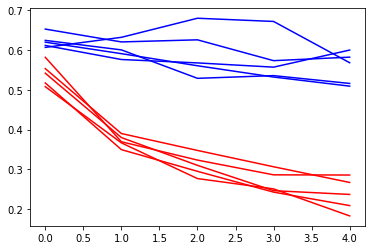

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
import collections

for i in range(5):
  model_ft = models.alexnet(pretrained=True)

  newFeatures=collections.OrderedDict()
  c=0
  d=0
  for layer in iter(model_ft.features):
    #print(layer)
    a=f'{c}' + '-' + f'{d}'
    d+=1
    newFeatures[a]=layer
    if isinstance(layer,nn.Conv2d):
      a=f'{c}' + '-' + f'{d}'
      newFeatures[a]=nn.Dropout(0.5)
      d+=1
    if isinstance(layer,nn.MaxPool2d):
      c+=1
      d=0
  features=nn.Sequential(newFeatures)
  features=nn.Sequential(
      features,
      nn.Conv2d(256,2,1), #2048 for resnet50
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )
  model_ft=features.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  learner = UncertaintyLearner(model_ft,criterion)

  optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train{i}'],image_datasets[f'test{i}'])
  print(f'Fold {i}:')
  learner.train(5,64,128,batch_cap=32)
  predictions = learner.predict(image_datasets[f'test{i}'],32,2,100)
  labels = [image_datasets[f'test{i}'][j][1] for j in range(len(image_datasets[f'test{i}']))]
  confusion_matrix(predictions,labels)


In [0]:
label_evaluation=torch.argmax(predictions, dim=2)
#print(label_evaluation.size())
predicted_labels =(label_evaluation==1).sum(dim=0)
for element in predicted_labels:
  print(element)
#should take in account the 

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(8)
tensor(0)
tensor(0)
tensor(7)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(63)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(14)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor

In [0]:
def show_images(indexes,dataset,title=None):  
  """"Use pyplot to show the images of the dataset at indexes
  """
  images = torch.stack([dataset[i][0] for i in indexes.tolist()]) #Stack the images of dataset indexes
  labels = [dataset[i][1] for i in indexes.tolist()]
  plt.ion()
  images = torchvision.utils.make_grid(images)
  inp = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  print(labels)

In [0]:
show_images()